In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interp
from sklearn.metrics import  auc

In [127]:
precision=pd.read_csv('./precision_xgb.csv',header=None)
precision

,0,1,2,3,4,5,6,7,8,9,...,485,486,487,488,489,490,491,492,493,494
0,0.50000,0.500990,0.501984,0.502982,0.503984,0.504990,0.506000,0.507014,0.508032,0.509054,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.50000,0.500990,0.501984,0.502982,0.503984,0.504990,0.506000,0.507014,0.508032,0.509054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.50000,0.499010,0.500000,0.500994,0.501992,0.502994,0.504000,0.505010,0.506024,0.507042,...,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.50099,0.501984,0.502982,0.503984,0.504990,0.506000,0.505010,0.506024,0.507042,0.508065,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,0.50099,0.501984,0.502982,0.503984,0.504990,0.506000,0.507014,0.508032,0.509054,0.510081,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [128]:
recall=pd.read_csv('./recall_xgb.csv',header=None)
recall


,0,1,2,3,4,5,6,7,8,9,...,485,486,487,488,489,490,491,492,493,494
0,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,0.996047,0.996047,0.996047,0.996047,0.996047,0.996047,0.996047,0.996047,0.996047,...,0.007905,0.003953,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.996047,0.996047,0.996047,0.996047,...,0.015810,0.011858,0.007905,0.003953,0.000000,NaN,NaN,NaN,NaN,NaN
4,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.035573,0.031621,0.027668,0.023715,0.019763,0.01581,0.011858,0.007905,0.003953,0.0


In [129]:
auprs=pd.read_csv('./XGB.csv')[['auprs']]
auprs

,auprs
0,0.877930
1,0.860238
2,0.856616
3,0.880609
4,0.873864


In [130]:
def MyEnlarge(x0, y0, width, height, x1, y1, times, mean_fpr, mean_tpr, thickness=1, color = 'blue'):
    def MyFrame(x0, y0, width, height):
        import matplotlib.pyplot as plt
        import numpy as np

        x1 = np.linspace(x0, x0, num=20)  # 生成列的横坐标，横坐标都是x0，纵坐标变化
        y1 = np.linspace(y0, y0, num=20)
        xk = np.linspace(x0, x0 + width, num=20)
        yk = np.linspace(y0, y0 + height, num=20)

        xkn = []
        ykn = []
        counter = 0
        while counter < 20:
            xkn.append(x1[counter] + width)
            ykn.append(y1[counter] + height)
            counter = counter + 1

        plt.plot(x1, yk, color='k', linestyle=':', lw=1, alpha=1)  # 左
        plt.plot(xk, y1, color='k', linestyle=':', lw=1, alpha=1)  # 下
        plt.plot(xkn, yk, color='k', linestyle=':', lw=1, alpha=1)  # 右
        plt.plot(xk, ykn, color='k', linestyle=':', lw=1, alpha=1)  # 上

        return
    # 画虚线框
    width2 = times * width
    height2 = times * height
    MyFrame(x0, y0, width, height)
    MyFrame(x1, y1, width2, height2)

    # 连接两个虚线框
    xp = np.linspace(x0 , x1+width2, num=20)
    yp = np.linspace(y0, y1 + height2, num=20)
    plt.plot(xp, yp, color='k', linestyle=':', lw=1, alpha=1)

    # 小虚框内各点坐标
    XDottedLine = []
    YDottedLine = []
    counter = 0
    while counter < len(mean_fpr):
        if mean_fpr[counter] > x0 and mean_fpr[counter] < (x0 + width) and mean_tpr[counter] > y0 and mean_tpr[counter] < (y0 + height):
            XDottedLine.append(mean_fpr[counter])
            YDottedLine.append(mean_tpr[counter])
        counter = counter + 1

    # 画虚线框内的点
    # 把小虚框内的任一点减去小虚框左下角点生成相对坐标，再乘以倍数（4）加大虚框左下角点
    counter = 0
    while counter < len(XDottedLine):
        XDottedLine[counter] = (XDottedLine[counter] - x0) * times + x1
        YDottedLine[counter] = (YDottedLine[counter] - y0) * times + y1
        counter = counter + 1


    plt.plot(XDottedLine, YDottedLine, color=color, lw=thickness, alpha=1)
    return

In [131]:
np.mean(auprs['auprs'])

0.86985138955192

In [132]:
pres = []
#auprs = []
mean_res = np.linspace(0, 1, 1000)

colorlist = ['red', 'gold', 'purple', 'green', 'blue', 'black']

/var/folders/37/2brzhtcs52160y_wjzcp3k_h0000gn/T/ipykernel_1142/1605442119.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  pres.append(interp(mean_res, re, pre))


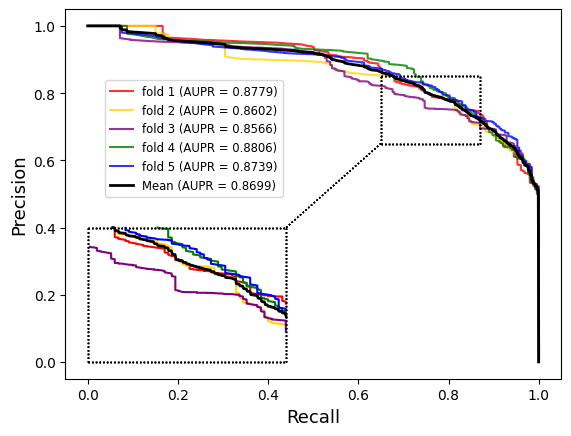

In [134]:
for i in range(len(precision)):
    pre=precision.iloc[i,:].dropna().tolist()
    pre.insert(0, 0)
    pre.sort(reverse=True)
    re=recall.iloc[i,:].dropna().tolist()
    re.insert(0, 1)
    re.sort()
    
    pres.append(interp(mean_res, re, pre))
    aupr=auprs.iloc[:,0].tolist()
    
    plt.plot(re, pre, lw=1.5, alpha=0.8, color=colorlist[i],label='fold %d (AUPR = %0.4f)' % (i+1, aupr[i]))
    #MyEnlarge(0.8, 0.8, 0.22, 0.2, 0, 0, 2, re,pre, 1.5, colorlist[i])
    MyEnlarge(0.65, 0.65, 0.22, 0.2, 0, 0, 2, re,pre, 1.5, colorlist[i])
mean_pres = np.mean(pres, axis=0)

plt.plot(mean_res,mean_pres ,color='black',label=r'Mean (AUPR = %.4f)' % (np.mean(aupr)),lw=2, alpha=1)
#MyEnlarge(0.8, 0.8, 0.22, 0.2, 0, 0, 2, mean_res ,mean_pres,2, colorlist[5])
MyEnlarge(0.65, 0.65, 0.22, 0.2, 0, 0, 2, mean_res ,mean_pres,2, colorlist[5])
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall',fontsize=13)
plt.ylabel('Precision',fontsize=13)
# plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(0.45, 0.65),fontsize='small')##0.45,0.65 对应右下
# plt.plot([0, 1], [1, 0], color='navy', lw=2, linestyle='--')
# plt.grid(linestyle='-')
# # 保存图片
plt.savefig('PR-5fold_XGB.svg',dpi=600)
plt.savefig('PR-5fold_XGB.tif',dpi=600)
plt.show()

##注：放大镜的位置只调 MyEnlarge的前两个参数，对应左下，要保证两处一致

# AUC

In [135]:
def ReadMyCsv(df):
    fprs=pd.read_csv(df,header=None)
    fpr=[]
    for index,row in fprs.iterrows():
        fpr.append(row.dropna().tolist())
    return fpr

In [136]:
def MyEnlarge(x0, y0, width, height, x1, y1, times, mean_fpr, mean_tpr, thickness=1, color='blue'):
    def MyFrame(x0, y0, width, height):
        import matplotlib.pyplot as plt
        import numpy as np

        x1 = np.linspace(x0, x0, num=20)
        y1 = np.linspace(y0, y0, num=20)
        xk = np.linspace(x0, x0 + width, num=20)
        yk = np.linspace(y0, y0 + height, num=20)

        xkn = []
        ykn = []
        counter = 0
        while counter < 20:
            xkn.append(x1[counter] + width)
            ykn.append(y1[counter] + height)
            counter = counter + 1

        plt.plot(x1, yk, color='k', linestyle=':', lw=1, alpha=1)  # 左
        plt.plot(xk, y1, color='k', linestyle=':', lw=1, alpha=1)  # 下
        plt.plot(xkn, yk, color='k', linestyle=':', lw=1, alpha=1)  # 右
        plt.plot(xk, ykn, color='k', linestyle=':', lw=1, alpha=1)  # 上

        return

    # 画虚线框
    width2 = times * width
    height2 = times * height
    MyFrame(x0, y0, width, height)
    MyFrame(x1, y1, width2, height2)

    # 连接两个虚线框
    xp = np.linspace(x0 + width, x1, num=20)
    yp = np.linspace(y0, y1 + height2, num=20)
    plt.plot(xp, yp, color='k', linestyle=':', lw=1, alpha=1)

    # 小虚框内各点坐标
    XDottedLine = []
    YDottedLine = []
    counter = 0
    while counter < len(mean_fpr):
        if mean_fpr[counter] > x0 and mean_fpr[counter] < (x0 + width) and mean_tpr[counter] > y0 and mean_tpr[
            counter] < (y0 + height):
            XDottedLine.append(mean_fpr[counter])
            YDottedLine.append(mean_tpr[counter])
        counter = counter + 1
    print(len(XDottedLine))
    print(len(YDottedLine))
    # 画虚线框内的点
    # 把小虚框内的任一点减去小虚框左下角点生成相对坐标，再乘以倍数（4）加大虚框左下角点
    counter = 0
    while counter < len(XDottedLine):
        XDottedLine[counter] = (XDottedLine[counter] - x0) * times + x1
        YDottedLine[counter] = (YDottedLine[counter] - y0) * times + y1
        counter = counter + 1

    plt.plot(XDottedLine, YDottedLine, color=color, lw=thickness, alpha=1)
    return


In [137]:
##需要运行生成auc_xgb.csv
pd.read_csv('./XGB.csv')[['aucs']].to_csv('./auc_xgb.csv',index=0,header=0)

In [138]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 1000)
i = 0
colorlist = ['red', 'gold', 'purple', 'green', 'blue', 'black']
RealAndPrediction = []
AllResult = []

counter = 0

fpr=[]
tpr=[]
tprs=[]
aucss=[]
mean_fpr = np.linspace(0, 1, 1000)
##读入数据
fpr=ReadMyCsv('fprs_xgb.csv')
tpr=ReadMyCsv('tpr_xbg.csv')
aucss=ReadMyCsv('auc_xgb.csv')
a=pd.read_csv('./XGB.csv')[['aucs']]

In [139]:
aucss

[[0.866878095267853],
 [0.8579418519270727],
 [0.8546688746894967],
 [0.8724590626764541],
 [0.8737687433339607]]

In [140]:
a

,aucs
0,0.866878
1,0.857942
2,0.854669
3,0.872459
4,0.873769


In [141]:
np.mean(a['aucs'])

0.8651433255789674

[0.0, 0.0, 0.0, 0.0039525691699604, 0.0039525691699604, 0.0079051383399209, 0.0079051383399209, 0.0118577075098814, 0.0118577075098814, 0.0118577075098814, 0.0118577075098814, 0.0118577075098814, 0.0118577075098814, 0.0118577075098814, 0.0118577075098814, 0.0158102766798418, 0.0158102766798418, 0.0197628458498023, 0.0197628458498023, 0.0237154150197628, 0.0237154150197628, 0.0276679841897233, 0.0276679841897233, 0.0316205533596837, 0.0316205533596837, 0.0395256916996047, 0.0395256916996047, 0.0434782608695652, 0.0434782608695652, 0.0513833992094861, 0.0513833992094861, 0.0553359683794466, 0.0553359683794466, 0.0592885375494071, 0.0592885375494071, 0.0592885375494071, 0.0592885375494071, 0.0632411067193675, 0.0632411067193675, 0.0632411067193675, 0.0632411067193675, 0.0711462450592885, 0.0711462450592885, 0.075098814229249, 0.075098814229249, 0.0790513833992094, 0.0790513833992094, 0.0869565217391304, 0.0909090909090909, 0.0948616600790513, 0.0948616600790513, 0.1067193675889328, 0.1067

/var/folders/37/2brzhtcs52160y_wjzcp3k_h0000gn/T/ipykernel_1142/3622585813.py:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  tprs.append(interp(mean_fpr,fpr1,tpr1))


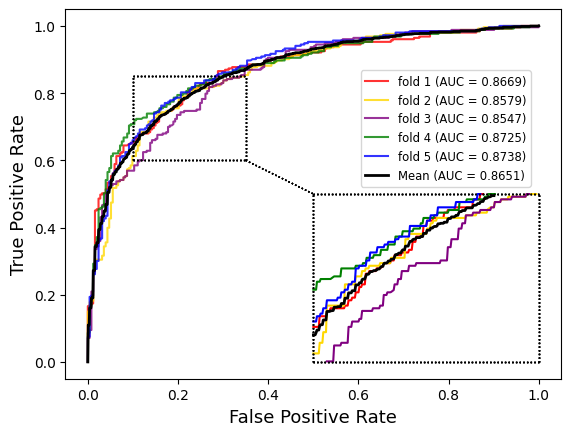

In [144]:
i=0
while i<5:
    fpr1=[]
    tpr1=[]
    print(fpr[i])
    for x in fpr[i]:  fpr1.append(float(x))
    for xx in tpr[i]: tpr1.append(float(xx))
    
    tprs.append(interp(mean_fpr,fpr1,tpr1))
    tprs[-1][0]=0.0

    fpr1.insert(0, 0)
    tpr1.insert(0, 0)

    auc1=float(a['aucs'].tolist()[i])
    plt.plot(fpr1, tpr1, lw=1.5, alpha=0.8, color=colorlist[i],
             label='fold %d (AUC = %0.4f)'% (i+1,auc1))
    MyEnlarge(0.1, 0.6, 0.25, 0.25, 0.5, 0, 2, mean_fpr, tprs[i], 1.5, colorlist[i])
    i+=1

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(a)#auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='black',
         label=r'Mean (AUC = %0.4f)' % (mean_auc),
         lw=2, alpha=1)
MyEnlarge(0.1, 0.6, 0.25, 0.25, 0.5, 0, 2, mean_fpr, mean_tpr, 2, colorlist[5])

FprAndTpr = []
counter = 0
while counter < len(mean_fpr):
    pair = []
    pair.append(mean_fpr[counter])
    pair.append(mean_tpr[counter])
    FprAndTpr.append(pair)
    counter = counter + 1


plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
# plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(0.95, 0.85),loc='upper right', fontsize='small')
#
# 保存图片
plt.savefig('5fold-manner_xgb.svg',dpi=600)
plt.savefig('5fold-manner_xgb.tif',dpi=600)
plt.show()